In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bi-ml-competition-2023:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F49431%2F5228520%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240311%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240311T140336Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0439a6647118ef93fac3b8d2f72135cfd433fa2ff3d0992a9bb24360bf7e359ce6346e0acb775939df8562e3d5ce4efb67bf65176232bd7293a8398aa85ebc4751da621a3cacef50ff5146703ffdff98d954899ee2baa8cf917f55500c0917d2f532b56b4417aa1ec82004552736d80fdc551ea663815efdb030039529fb4bbe7f4cfc7a9d859ef8ec998a3d5e8792b96eedf04e359fa2cc87bc5a691514009a2b428db00d65db322390551a6651afabef44689b1d40bfd1670fa5ff224f377ce4821e5f3b4f1a39b14007b4a62c1855d6e2f7348d17370c1dca2a4a17aa19cfeb7286b7427a95c9ca95d1190483075c33f893db9fc8526f59e53fee57f34673'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку.

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [3]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

%matplotlib inline

In [4]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [5]:
PATH_TO_DATA = "/kaggle/input/copy-of-23-24-ml/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,
                                             "train_data.csv"),
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA,
                                            "train_targets.csv"),
                                   index_col="match_id_hash")


In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


In [7]:
df_train_features.shape

(31698, 245)

In [8]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [9]:
# посмотрим на список (названия) всех признаков команд
column_names = df_train_features.columns

column_names_list = df_train_features.columns.tolist()
columns_df = pd.DataFrame(column_names_list, columns=['Column Names'])

# Запись DataFrame в CSV-файл
columns_df.to_csv('column_names.csv', index=False)
column_names_df = pd.read_csv('column_names.csv')
pd.set_option('display.max_rows', 245)
print (column_names_df)

                   Column Names
0                     game_time
1                     game_mode
2                    lobby_type
3                objectives_len
4                      chat_len
5                    r1_hero_id
6                      r1_kills
7                     r1_deaths
8                    r1_assists
9                     r1_denies
10                      r1_gold
11                        r1_lh
12                        r1_xp
13                    r1_health
14                r1_max_health
15                  r1_max_mana
16                     r1_level
17                         r1_x
18                         r1_y
19                     r1_stuns
20            r1_creeps_stacked
21             r1_camps_stacked
22              r1_rune_pickups
23        r1_firstblood_claimed
24   r1_teamfight_participation
25             r1_towers_killed
26            r1_roshans_killed
27                r1_obs_placed
28                r1_sen_placed
29                   r2_hero_id
30      

Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [13]:
# Cозданим новый признак, который будет аггрегировать в себе прогресс героя в игре: Уровень (level), Опыт (xp) и Золото (gold), и назовем его "lgxp".
# gold является одним из ключевых ресурсов, который игроки используют для покупки предметов для своих героев. Получить золото можно несколькими способами: 
# пассивно, в течение игры, за убийство героев, уничтожение строений, через специальные руны золота, дающие дополнительное золото игроку, который ее собирает, и его команде,
# некоторые предметы и способности героев могут увеличивать количество получаемого золота или давать его за выполнение определенных условий.
# Таким образом, показатель Золото в некотором смысле аггрегирует в себе вышеназванные показатели, соответственно может быть может быть неплохим признаком.
# 'lgxp' показатель считается простым суммированием значений level, Опыт (xp) и Золото (gold) для всех игроков команды.



In [15]:
#добавим в датафрейм d_lgxp
df_train_features['d_lgxp'] = df_train_features['d1_gold'] + df_train_features['d1_level'] + df_train_features['d1_xp'] + df_train_features['d2_gold'] + df_train_features['d2_level'] + df_train_features['d2_xp'] + df_train_features['d3_gold'] + df_train_features['d3_level'] + df_train_features['d3_xp'] + df_train_features['d4_gold'] + df_train_features['d4_level'] + df_train_features['d4_xp'] + df_train_features['d5_gold'] + df_train_features['d5_level'] + df_train_features['d5_xp']
df_train_features['r_lgxp'] = df_train_features['r1_gold'] + df_train_features['r1_level'] + df_train_features['r1_xp'] + df_train_features['r2_gold'] + df_train_features['r2_level'] + df_train_features['r2_xp'] + df_train_features['r3_gold'] + df_train_features['r3_level'] + df_train_features['r3_xp'] + df_train_features['r4_gold'] + df_train_features['r4_level'] + df_train_features['r4_xp'] + df_train_features['r5_gold'] + df_train_features['r5_level'] + df_train_features['r5_xp']

In [19]:
df_train_features.shape
df_train_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d_lgxp,r_lgxp,index_lgxp
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.000000,0,0,0,0,26099,35775,1
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.000000,0,0,0,0,485,885,1
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.000000,0,0,0,0,4367,5901,1
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.250000,0,0,3,0,48209,49814,1
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.500000,0,0,3,0,27045,25701,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,17,0,0.390244,2,2,0,0,210260,186412,0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,10,0,0.263158,0,0,15,6,159211,190171,1
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,15,1,0.555556,0,0,0,0,53051,44239,0


In [18]:
#добавим в датафрейм колонку "index_lgxp" со значениями 0, если #добавим в датафрейм r_lgxp > d_lgxp, и 1, если r_lgxp  < d_lgxp
df_train_features['index_lgxp'] = np.where(df_train_features['r_lgxp'] > df_train_features['d_lgxp'], 1, 0)

In [20]:

df_train_features


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,d_lgxp,r_lgxp,index_lgxp
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.000000,0,0,0,0,26099,35775,1
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.000000,0,0,0,0,485,885,1
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.000000,0,0,0,0,4367,5901,1
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.250000,0,0,3,0,48209,49814,1
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.500000,0,0,3,0,27045,25701,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,9,11,9,3,...,17,0,0.390244,2,2,0,0,210260,186412,0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,9,14,3,...,10,0,0.263158,0,0,15,6,159211,190171,1
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,1,2,1,0,...,15,1,0.555556,0,0,0,0,53051,44239,0


In [9]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [21]:
#обучим модель с тремя дополнительными признаками
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")
X


array([[6.5800e+02, 4.0000e+00, 0.0000e+00, ..., 2.6099e+04, 3.5775e+04,
        1.0000e+00],
       [2.1000e+01, 2.3000e+01, 0.0000e+00, ..., 4.8500e+02, 8.8500e+02,
        1.0000e+00],
       [1.6000e+02, 2.2000e+01, 7.0000e+00, ..., 4.3670e+03, 5.9010e+03,
        1.0000e+00],
       ...,
       [1.0020e+03, 4.0000e+00, 0.0000e+00, ..., 5.3051e+04, 4.4239e+04,
        0.0000e+00],
       [3.7700e+02, 2.2000e+01, 7.0000e+00, ..., 1.6980e+04, 1.4235e+04,
        0.0000e+00],
       [6.4300e+02, 2.2000e+01, 7.0000e+00, ..., 3.5030e+04, 2.3595e+04,
        0.0000e+00]])

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.3,
                                                      random_state=SEED)

#### Обучим случайный лес

In [23]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 36.8 s, sys: 98.4 ms, total: 36.9 s
Wall time: 10.2 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [24]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]
y_pred 

array([0.71137297, 0.52425227, 0.33780164, ..., 0.63969521, 0.39909681,
       0.64786807])

In [26]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7963862376587856


Посмотрим на accuracy:

In [27]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.7220820189274448


In [28]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"),
                                   index_col="match_id_hash")


In [29]:
df_test_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,8.664527,3,1,3,0,0.000000,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.000000,2,1,2,0,0.250000,0,0,0,0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,0.000000,0,0,1,0,0.125000,0,0,0,0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,0.766459,0,0,1,0,1.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,2,0,0,1,...,0.000000,3,2,0,0,0.000000,0,0,0,0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,2,9,1,6,...,149.551700,0,0,20,0,0.395833,0,0,4,0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,1,9,9,0,...,26.493834,6,2,3,0,0.562500,0,0,7,2


In [31]:
#рассчитаем значения новых признаков для тестовых данных
df_test_features['r_lgxp'] = df_test_features['r1_gold'] + df_test_features['r1_level'] + df_test_features['r1_xp'] + df_test_features['r2_gold'] + df_test_features['r2_level'] + df_test_features['r2_xp'] + df_test_features['r3_gold'] + df_test_features['r3_level'] + df_test_features['r3_xp'] + df_test_features['r4_gold'] + df_test_features['r4_level'] + df_test_features['r4_xp'] + df_test_features['r5_gold'] + df_test_features['r5_level'] + df_test_features['r5_xp']
df_test_features['d_lgxp'] = df_test_features['d1_gold'] + df_test_features['d1_level'] + df_test_features['d1_xp'] + df_test_features['d2_gold'] + df_test_features['d2_level'] + df_test_features['d2_xp'] + df_test_features['d3_gold'] + df_test_features['d3_level'] + df_test_features['d3_xp'] + df_test_features['d4_gold'] + df_test_features['d4_level'] + df_test_features['d4_xp'] + df_test_features['d5_gold'] + df_test_features['d5_level'] + df_test_features['d5_xp']


In [33]:
df_test_features['index_lgxp'] = np.where(df_test_features['r_lgxp'] > df_test_features['d_lgxp'], 1, 0)
df_test_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,r_lgxp,d_lgxp,index_lgxp
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0,0,0.000000,0,0,0,0,4037,7045,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,3,0,0.000000,0,0,2,0,28043,23172,1
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,2,0,0.250000,0,0,0,0,17866,20009,0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,1,0,0.125000,0,0,0,0,34917,32788,1
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,1,0,1.000000,0,0,0,0,37182,34654,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,2,0,0,1,...,0,0,0.000000,0,0,0,0,25328,20439,1
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,2,9,1,6,...,20,0,0.395833,0,0,4,0,180477,196203,0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,1,9,9,0,...,3,0,0.562500,0,0,7,2,105964,117010,0


## <left>Посылка

In [34]:

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred},
                                 index=df_test_features.index)



In [35]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2024-04-01_08-14-16.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [36]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [37]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 3min 5s, sys: 608 ms, total: 3min 6s
Wall time: 49.9 s


In [38]:
cv_scores_rf

array([0.79638624, 0.79694695, 0.79199912, 0.79746994, 0.79627322])

In [39]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

#Видно, что случайный лес стал работать немного лучше при добавлении новых признаков.

Среднее значение ROC-AUC на кросс-валидации: 0.7958150932774692


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [22]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()

    # переведем JSON в питоновский словарь
    match = json.loads(line)
    match

In [23]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [24]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

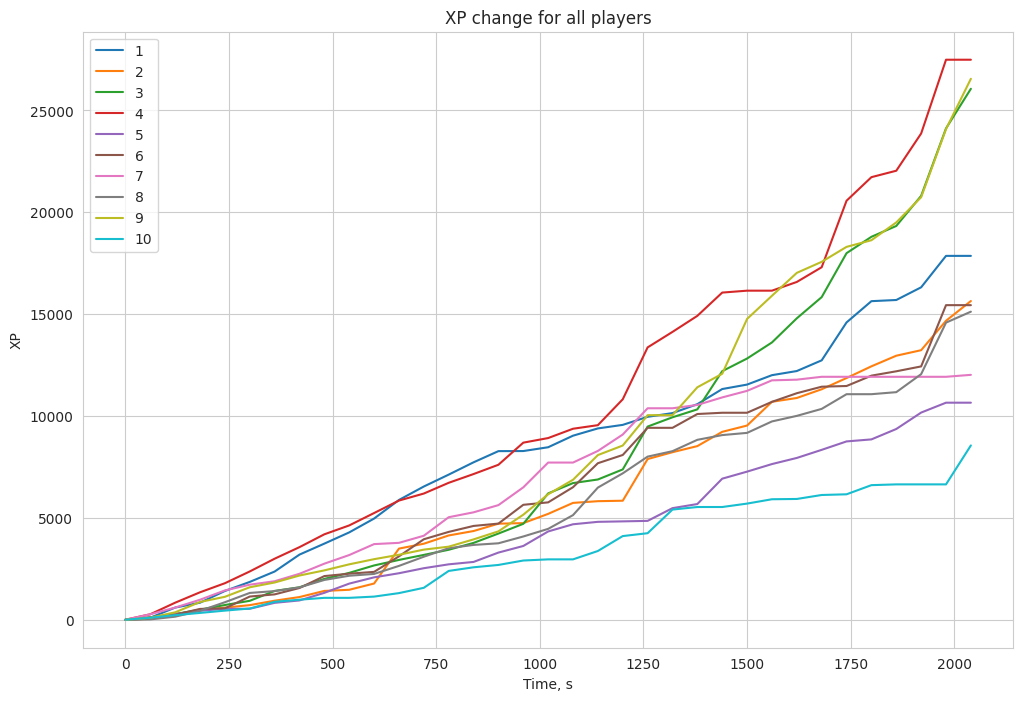

In [25]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [32]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")

try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")


def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Возвращает записи о каждом матче
    """

    if n_matches_to_read is None:
        n_matches_to_read = total_matches

    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [27]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными

    Результат
    ---------
    Добавляет новые признаки в таблицу
    """

    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [33]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended,
                 os.path.join(PATH_TO_DATA,
                              "train_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

In [29]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [30]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y,
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 546 ms, sys: 401 ms, total: 948 ms
Wall time: 1min 52s


In [31]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!